 # Quick comparison of PCN and BioPCN on MNIST

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pydove as dv

import numpy as np
import torch

from cpcn import LinearBioPCN, PCNetwork, load_mnist

 ## Setup

In [2]:
device = torch.device("cpu")
dataset = load_mnist(n_validation=1000, device=device)

 ## Train PCN

In [3]:
dims = [784, 5, 10]
it_inference = 150
lr_inference = 0.07
rho = 0.015
# rho = 0.0012

seed = 123

torch.manual_seed(seed)

pcn = PCNetwork(
    dims,
    activation=lambda _: _,
    lr_inference=lr_inference,
    it_inference=it_inference,
    variances=1.0,
    constrained=True,
    rho=rho,
    bias=False,
).to(device)

z_it = 250
z_lr = 0.2

torch.manual_seed(seed)

# match the PCN network
g_a = 0.5 * np.ones(len(dims) - 2)
g_a[-1] *= 2

g_b = 0.5 * np.ones(len(dims) - 2)
g_b[0] *= 2

biopcn = LinearBioPCN(
    dims,
    z_lr=z_lr,
    z_it=z_it,
    g_a=g_a,
    g_b=g_b,
    c_m=0,
    l_s=g_b,
    rho=rho,
    bias_a=False,
    bias_b=False,
    q0_scale=np.sqrt(1 + dims[2] / dims[1]),
).to(device)

 ## Compare the weights

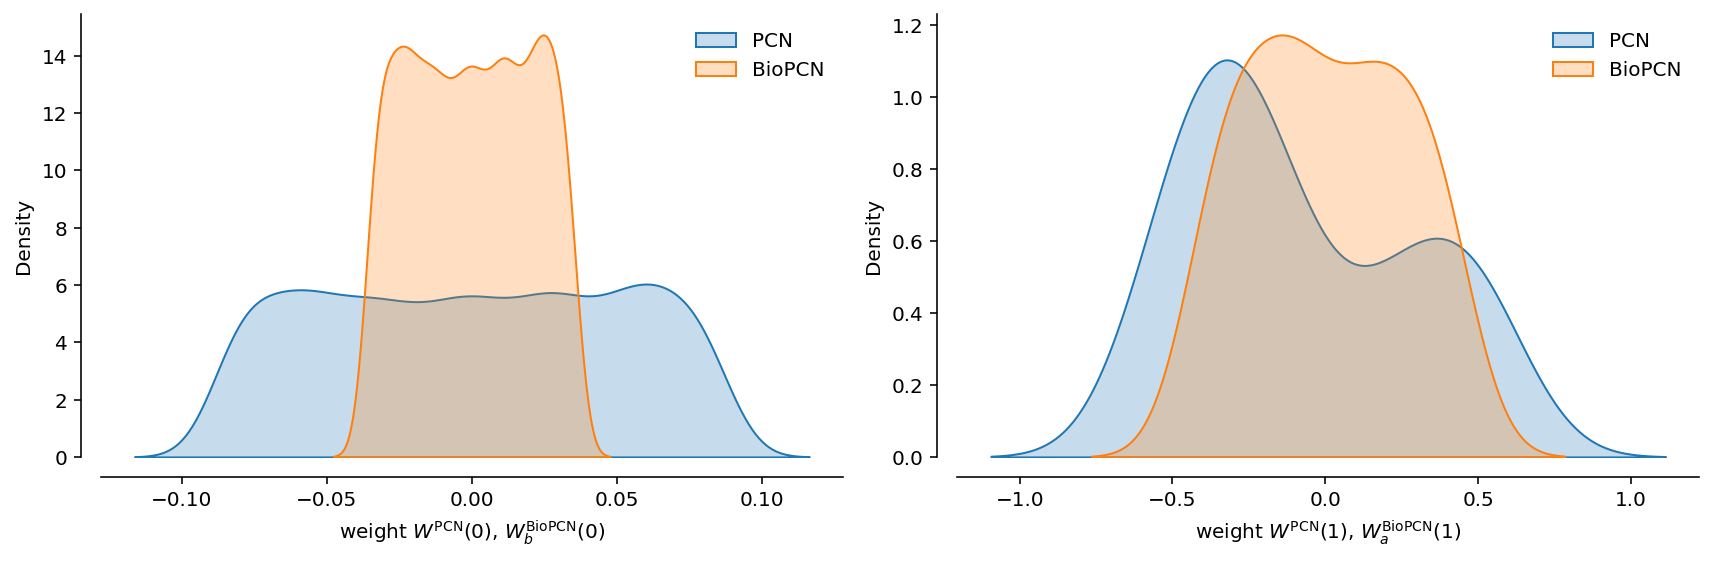

In [4]:
with dv.FigureManager(1, 2) as (_, (ax1, ax2)):
    sns.kdeplot(pcn.W[0].detach().numpy().ravel(), label="PCN", fill=True, ax=ax1)
    sns.kdeplot(
        biopcn.W_b[0].detach().numpy().ravel(), label="BioPCN", fill=True, ax=ax1
    )

    ax1.legend(frameon=False)
    ax1.set_xlabel("weight $W^{\\rm{PCN}}(0)$, $W^{\\rm{BioPCN}}_b(0)$")

    sns.kdeplot(pcn.W[1].detach().numpy().ravel(), label="PCN", fill=True, ax=ax2)
    sns.kdeplot(
        biopcn.W_a[0].detach().numpy().ravel(), label="BioPCN", fill=True, ax=ax2
    )

    ax2.legend(frameon=False)
    ax2.set_xlabel("weight $W^{\\rm{PCN}}(1)$, $W^{\\rm{BioPCN}}_a(1)$")

 ## Compare the activations after `relax`

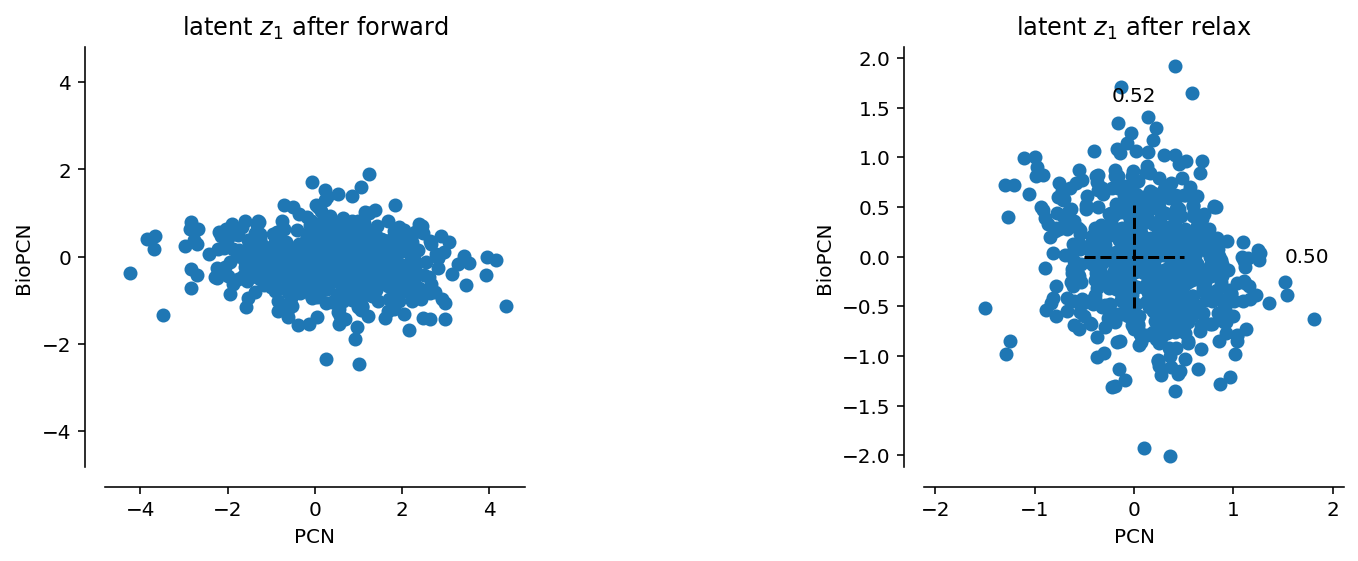

In [5]:
torch.manual_seed(seed)
sample = next(iter(dataset["train"]))
pcn_profile = pcn.relax(*sample, pc_loss_profile=True, latent_profile=True)
biopcn_profile = biopcn.relax(*sample, pc_loss_profile=True, latent_profile=True)

with dv.FigureManager(1, 2) as (_, (ax1, ax2)):
    fwd_pcn = pcn.forward(sample[0], inplace=False)
    fwd_biopcn = biopcn.forward(sample[0], inplace=False)

    ax1.scatter(fwd_pcn[1].detach(), fwd_biopcn[1].detach())
    ax1.set_xlabel("PCN")
    ax1.set_ylabel("BioPCN")
    ax1.set_title("latent $z_1$ after forward")
    ax1.set_aspect(1)

    crt_lim = max(max(*ax1.get_xlim()), max(*ax1.get_ylim()))
    ax1.set_xlim(-crt_lim, crt_lim)
    ax1.set_ylim(-crt_lim, crt_lim)

    ax2.scatter(pcn.z[1].detach(), biopcn.z[1])
    ax2.set_xlabel("PCN")
    ax2.set_ylabel("BioPCN")
    ax2.set_title("latent $z_1$ after relax")
    ax2.set_aspect(1)

    crt_lim = max(max(*ax2.get_xlim()), max(*ax2.get_ylim()))
    ax2.set_xlim(-crt_lim, crt_lim)
    ax2.set_ylim(-crt_lim, crt_lim)

    sigma_pcn = torch.std(pcn.z[1].detach())
    sigma_biopcn = torch.std(biopcn.z[1].detach())
    ax2.plot([-sigma_pcn, sigma_pcn], [0, 0], ls="--", c="k")
    ax2.plot([0, 0], [-sigma_biopcn, sigma_biopcn], ls="--", c="k")

    ax2.annotate(f"{sigma_pcn:.2f}", (3 * sigma_pcn, 0), va="center")
    ax2.annotate(f"{sigma_biopcn:.2f}", (0, 3 * sigma_biopcn), ha="center")

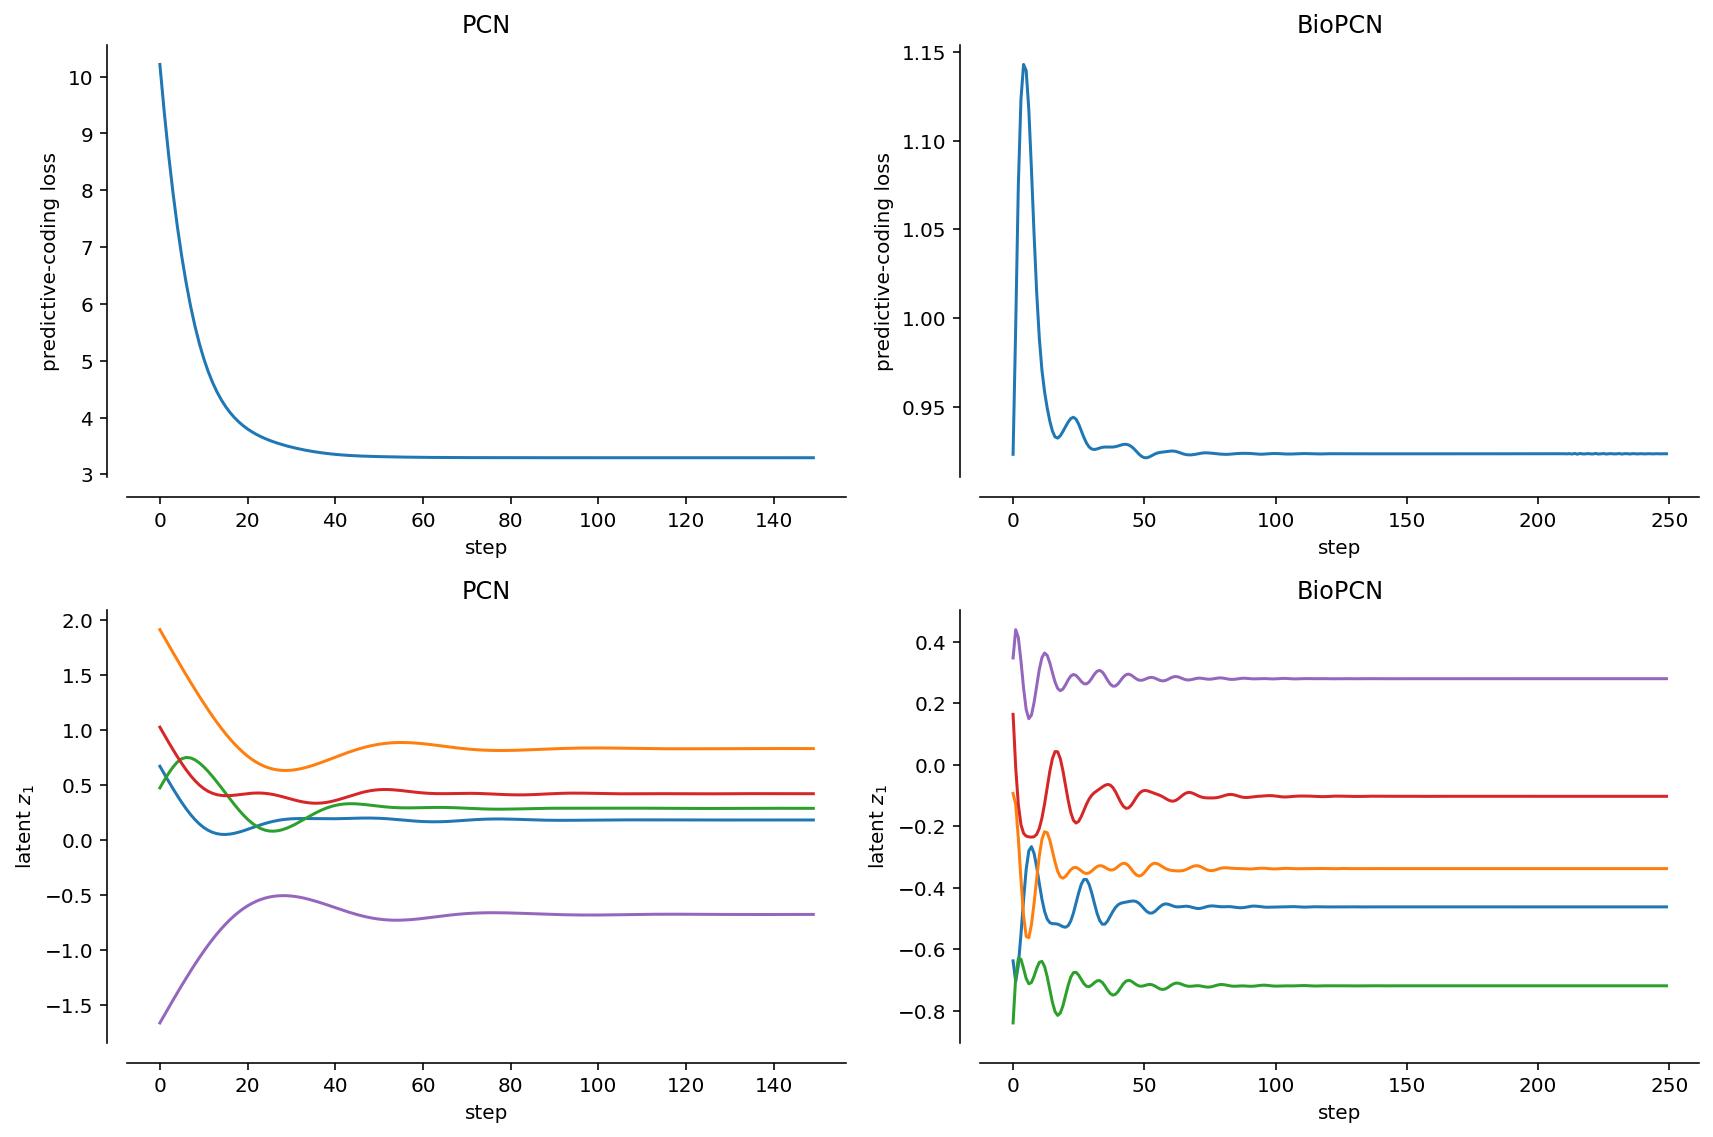

In [6]:
with dv.FigureManager(2, 2) as (_, (axs_loss, axs_z)):
    axs_loss[0].plot(pcn_profile.pc_loss.detach())
    axs_loss[0].set_title("PCN")
    axs_loss[1].plot(biopcn_profile.pc_loss)
    axs_loss[1].set_title("BioPCN")

    for ax in axs_loss:
        ax.set_xlabel("step")
        ax.set_ylabel("predictive-coding loss")

    axs_z[0].plot(pcn_profile.latent.z[1].detach()[:, -1, :])
    axs_z[0].set_title("PCN")
    axs_z[1].plot(biopcn_profile.latent.z[1].detach()[:, -1, :])
    axs_z[1].set_title("BioPCN")

    for ax in axs_z:
        ax.set_xlabel("step")
        ax.set_ylabel("latent $z_1$")

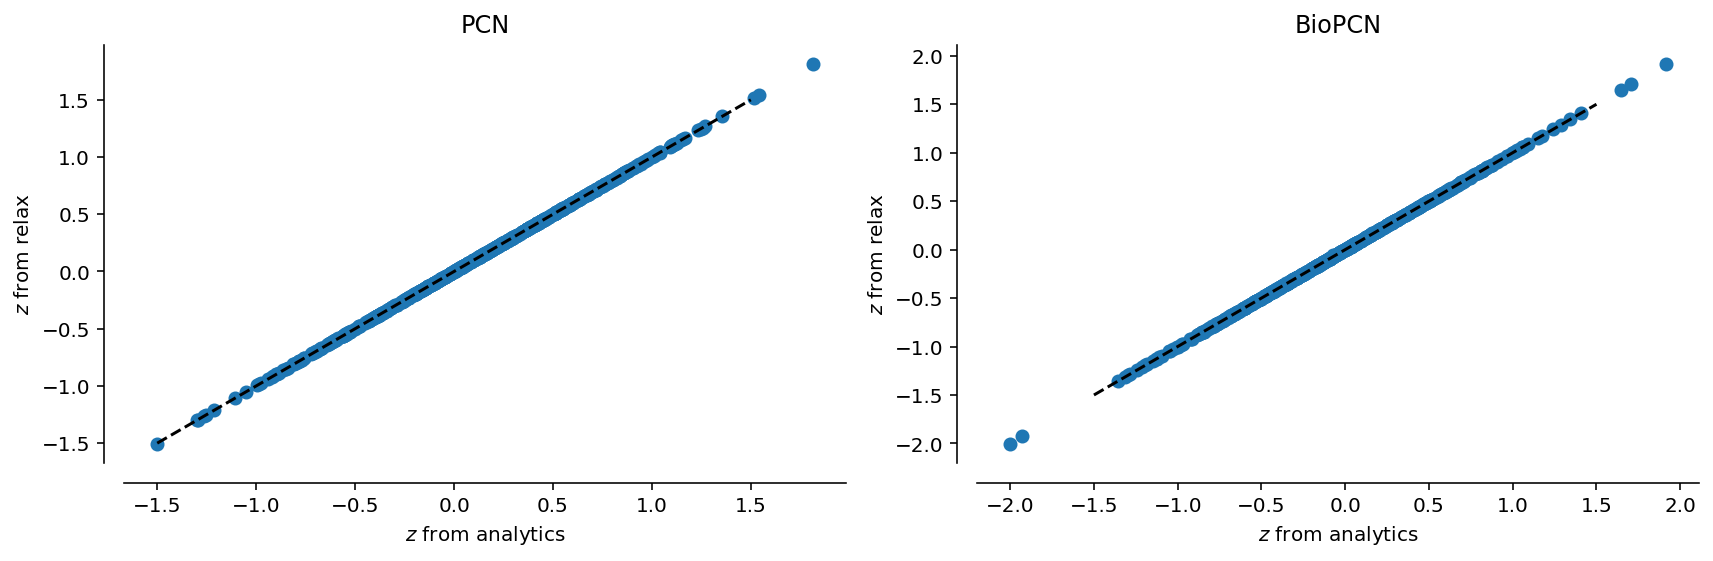

In [7]:
pcn_coeff_mat = torch.eye(dims[1]) + pcn.W[1].T @ pcn.W[1]
if pcn.constrained:
    pcn_coeff_mat += pcn.Q[0].T @ pcn.Q[0]
pcn_target = pcn.W[0] @ sample[0].T + pcn.W[1].T @ sample[1].T
pcn_pred = torch.linalg.solve(pcn_coeff_mat, pcn_target).T

biopcn_coeff_mat = torch.eye(dims[1]) + biopcn.Q[0].T @ biopcn.Q[0]
biopcn_target = biopcn.W_b[0] @ sample[0].T + biopcn.W_a[0].T @ sample[1].T
biopcn_pred = torch.linalg.solve(biopcn_coeff_mat, biopcn_target).T

with dv.FigureManager(1, 2) as (_, (ax1, ax2)):
    ax1.plot([-1.5, 1.5], [-1.5, 1.5], c="k", ls="--")
    ax1.scatter(pcn_pred.detach().ravel(), pcn.z[1].detach().ravel())
    ax1.set_xlabel("$z$ from analytics")
    ax1.set_ylabel("$z$ from relax")
    ax1.set_title("PCN")

    ax2.plot([-1.5, 1.5], [-1.5, 1.5], c="k", ls="--")
    ax2.scatter(biopcn_pred.detach().ravel(), biopcn.z[1].detach().ravel())
    ax2.set_xlabel("$z$ from analytics")
    ax2.set_ylabel("$z$ from relax")
    ax2.set_title("BioPCN")

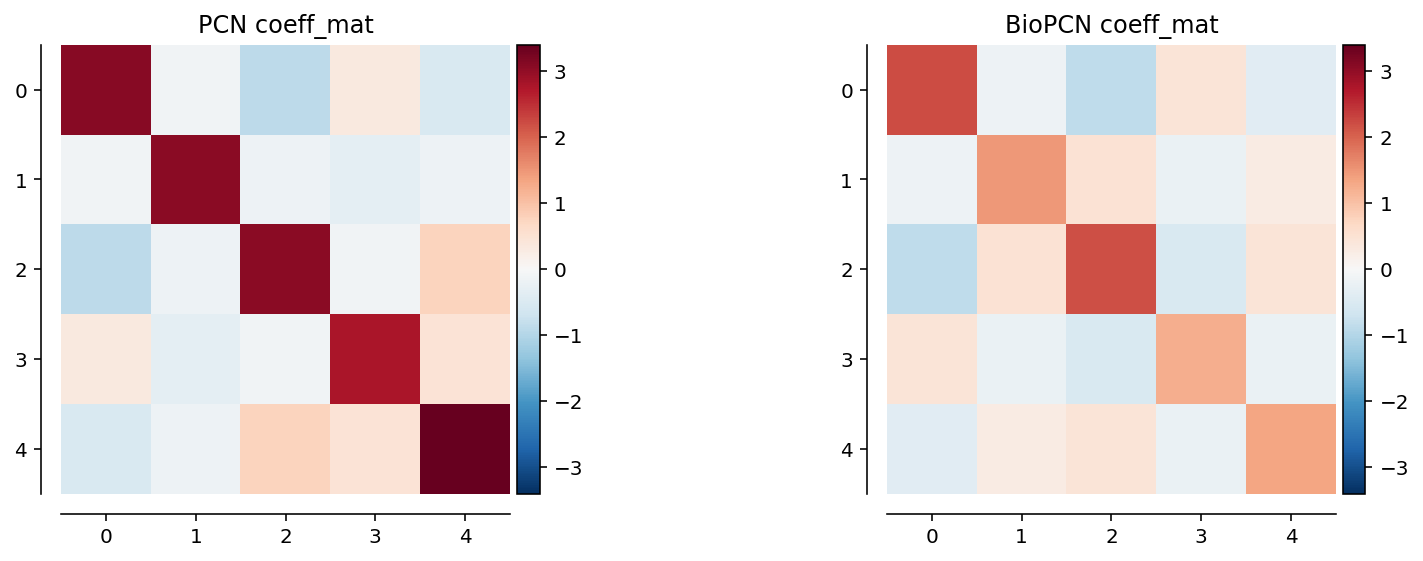

In [8]:
with dv.FigureManager(1, 2) as (_, (ax1, ax2)):
    crt_lim = max(
        torch.max(torch.abs(pcn_coeff_mat)), torch.max(torch.abs(biopcn_coeff_mat))
    )
    h1 = ax1.imshow(pcn_coeff_mat.detach(), vmin=-crt_lim, vmax=crt_lim, cmap="RdBu_r")
    h2 = ax2.imshow(
        biopcn_coeff_mat.detach(), vmin=-crt_lim, vmax=crt_lim, cmap="RdBu_r"
    )

    ax1.set_title("PCN coeff_mat")
    ax2.set_title("BioPCN coeff_mat")

    dv.colorbar(h1)
    dv.colorbar(h2)

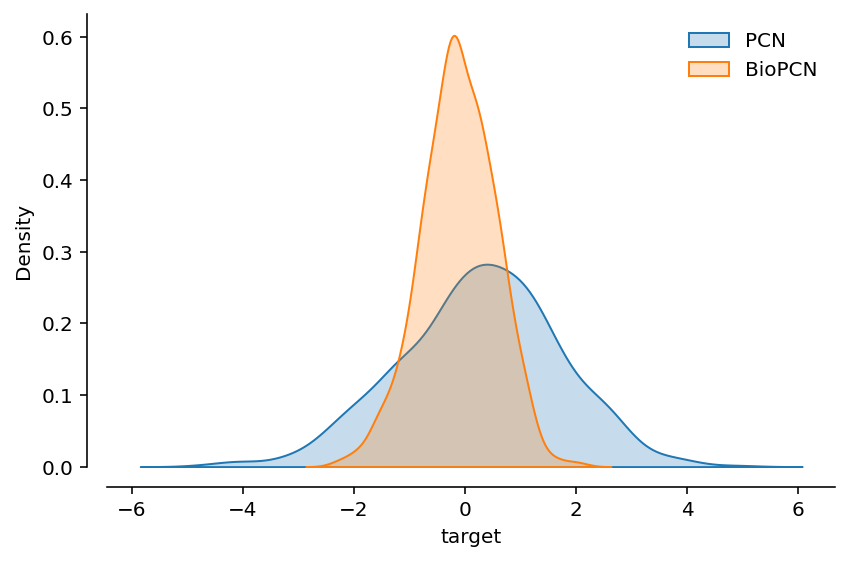

In [9]:
with dv.FigureManager() as (_, ax):
    sns.kdeplot(pcn_target.ravel().detach(), ax=ax, fill=True, label="PCN")
    sns.kdeplot(biopcn_target.ravel().detach(), ax=ax, fill=True, label="BioPCN")
    ax.legend(frameon=False)
    ax.set_xlabel("target")